<a href="https://colab.research.google.com/github/Ganesh-Kdt/Assignment-2-NN/blob/neural_network_part1/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#load the dataset through drive
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset.csv')
df.head()
print(df.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(766, 8)


In [2]:
#main statistics related to our dataset
df.info()
df=df.apply(pd.to_numeric,errors='coerce')
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   f1      766 non-null    object
 1   f2      766 non-null    object
 2   f3      766 non-null    int64 
 3   f4      766 non-null    object
 4   f5      766 non-null    object
 5   f6      766 non-null    object
 6   f7      766 non-null    object
 7   target  766 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 48.0+ KB


,f1,f2,f3,f4,f5,f6,f7,target
count,765.000000,765.000000,766.000000,765.000000,765.000000,765.000000,765.000000,766.000000
mean,3.849673,120.909804,69.118799,20.542484,80.091503,31.998170,0.472128,0.349869
std,3.373696,31.947945,19.376901,15.960515,115.374383,7.898275,0.331545,0.477240
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,0.000000
25%,1.000000,99.000000,62.500000,0.000000,0.000000,27.300000,0.244000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,36.000000,32.000000,0.374000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,128.000000,36.600000,0.626000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,1.000000


In [3]:
#converting NA values into median
for column in df.columns:
    unique_values = df[column].unique()
    for column_value in unique_values:
        if not isinstance(column_value, (int, float)):
            print(f"Invalid value '{column_value}' in column '{column}'")

for column in df.columns:
    if df[column].isna().any():
          df[column] = df[column].fillna(df[column].median())

Invalid value '72' in column 'f3'
Invalid value '66' in column 'f3'
Invalid value '64' in column 'f3'
Invalid value '40' in column 'f3'
Invalid value '74' in column 'f3'
Invalid value '50' in column 'f3'
Invalid value '0' in column 'f3'
Invalid value '70' in column 'f3'
Invalid value '96' in column 'f3'
Invalid value '92' in column 'f3'
Invalid value '80' in column 'f3'
Invalid value '60' in column 'f3'
Invalid value '84' in column 'f3'
Invalid value '30' in column 'f3'
Invalid value '88' in column 'f3'
Invalid value '90' in column 'f3'
Invalid value '94' in column 'f3'
Invalid value '76' in column 'f3'
Invalid value '82' in column 'f3'
Invalid value '75' in column 'f3'
Invalid value '58' in column 'f3'
Invalid value '78' in column 'f3'
Invalid value '68' in column 'f3'
Invalid value '110' in column 'f3'
Invalid value '56' in column 'f3'
Invalid value '62' in column 'f3'
Invalid value '85' in column 'f3'
Invalid value '86' in column 'f3'
Invalid value '48' in column 'f3'
Invalid value 

In [4]:
columns=['f1','f2','f3','f4','f5','f6','f7']
# def impute_outlier(df, column):
#     impute_column = df[column]
#     q1 = df[column].quantile(0.25)
#     q3 = df[column].quantile(0.75)
#     iqr = q3 - q1

#     lower_bound = q1 - 1.5 * iqr
#     upper_bound = q3 + 1.5 * iqr

#     non_outlier_median = impute_column[(df[column] >= lower_bound) & (df[column] <= upper_bound)].median()

#     def impute_value(value):
#         if value < lower_bound or value > upper_bound:
#             return non_outlier_median
#         else:
#             return value

#     df[column] = df[column].apply(impute_value)

# for column in columns:
#     impute_outlier(df, column)

# def normalize(df,column):
#     column_min = df[column].min()
#     column_max = df[column].max()
#     print("Minimum value for ",column," is: ",column_min)
#     print("Maximum value for ",column," is: ",column_max)
#     df[column] = (df[column] - column_min) / (column_max - column_min)

# for column in columns:
#     normalize(df,column)

# df.head(100)

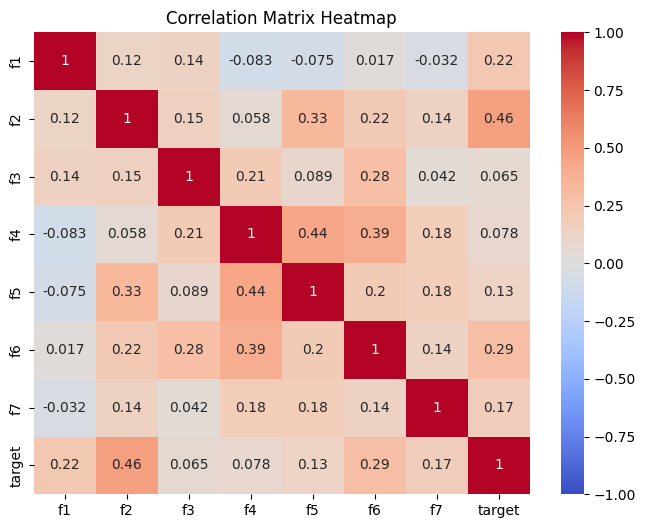

In [5]:
corr_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [6]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

#Scaling the dataset
X = df.drop(columns=['target','f3','f4','f5'])
y = df['target']
print(df['target'].value_counts())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Splitting the dataset into 70% training, 15% validation, 15% testing
X_temp, X_test, Y_temp, Y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.20, random_state=42, stratify=Y_temp)

smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_resampled.values, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32)

print("Training shape:", X_train_tensor.shape, Y_train_tensor.shape)
print("Validation shape:", X_val_tensor.shape, Y_val_tensor.shape)
print("Test shape:", X_test_tensor.shape, Y_test_tensor.shape)



target
0    498
1    268
Name: count, dtype: int64
Training shape: torch.Size([676, 4]) torch.Size([676])
Validation shape: torch.Size([131, 4]) torch.Size([131])
Test shape: torch.Size([115, 4]) torch.Size([115])


Validation loss improved from inf to 1.3211. Saving model...
Epoch [1/40], Training Loss: 0.6857, Validation Loss: 0.6606
Validation loss improved from 1.3211 to 1.2832. Saving model...
Epoch [2/40], Training Loss: 0.6499, Validation Loss: 0.6416
Validation loss improved from 1.2832 to 1.2406. Saving model...
Epoch [3/40], Training Loss: 0.6291, Validation Loss: 0.6203
Validation loss improved from 1.2406 to 1.2021. Saving model...
Epoch [4/40], Training Loss: 0.6056, Validation Loss: 0.6011
Validation loss improved from 1.2021 to 1.1707. Saving model...
Epoch [5/40], Training Loss: 0.5842, Validation Loss: 0.5853
Validation loss improved from 1.1707 to 1.1489. Saving model...
Epoch [6/40], Training Loss: 0.5590, Validation Loss: 0.5744
Validation loss improved from 1.1489 to 1.1352. Saving model...
Epoch [7/40], Training Loss: 0.5610, Validation Loss: 0.5676
Epoch [8/40], Training Loss: 0.5455, Validation Loss: 0.5694
Epoch [9/40], Training Loss: 0.5591, Validation Loss: 0.5753
Epoch 

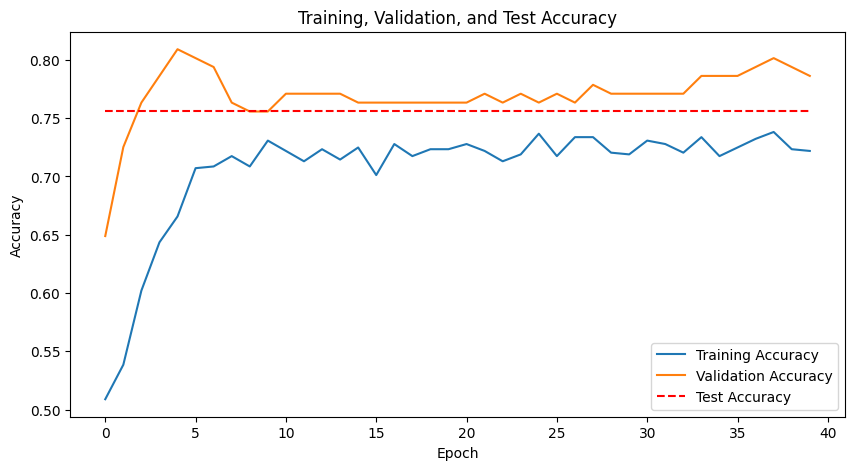

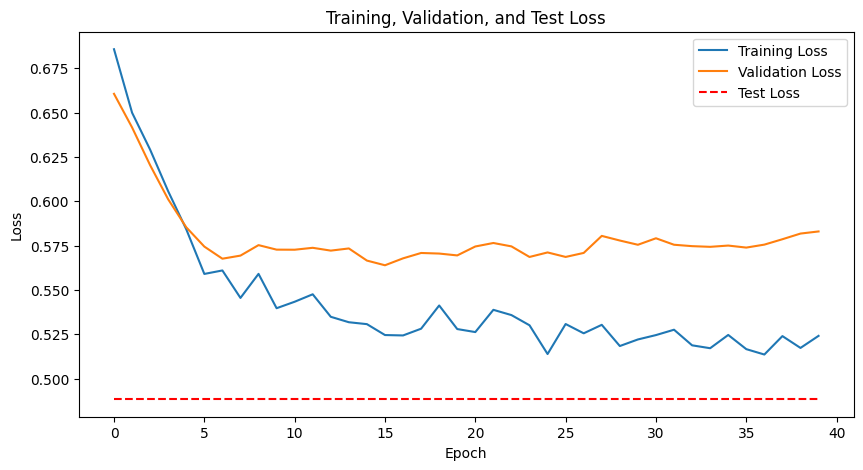

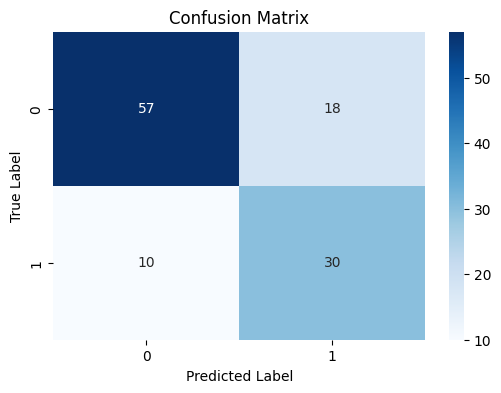

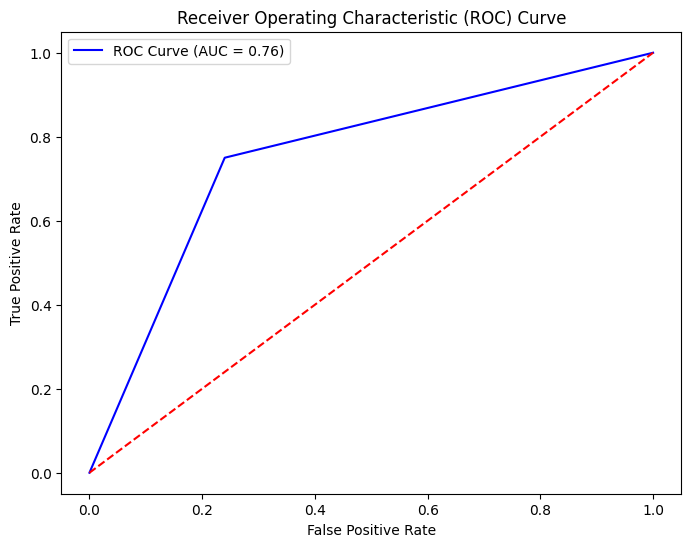

In [7]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc


# Step 1: Define the Neural Network architecture
class CustomNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size,dropout):
        super(CustomNeuralNetwork, self).__init__()
        # Input layer
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout)
        # Hidden layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size1)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout)
        # Output layer
        self.fc4 = nn.Linear(hidden_size1, output_size)
        self.sigmoid = nn.Sigmoid()  # Binary classification output

    def forward(self, x):
        output1 = self.fc1(x)
        output1 = self.relu1(output1)
        output1 = self.dropout(output1)
        output1 = self.fc2(output1)
        output2 = self.relu2(output1)
        output2 = self.dropout(output2)
        output3 = self.fc4(output2)
        output4 = self.sigmoid(output3)
        return output4

# Step 2: Initialize the model, loss function, and optimizer
input_size = 4  # Number of features
hidden_size1 = 64  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4

# model = CustomNeuralNetwork(input_size, hidden_size1, hidden_size2, output_size,dropout)
model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Train the model
epochs = 40  # Number of epochs
batch_size = 100  # Batch size

# DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, Y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_time = time.time()
# Save model weights
save_path = "best_model.pth"
best_val_loss = float('inf')
best_epoch = 0
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(), labels)  # Compute loss

        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        running_loss += loss.item()

        predicted_train = (outputs.squeeze() > 0.6).float()
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_labels).item()

            predicted_val = (val_outputs.squeeze() > 0.6).float()
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct_val / total_val)

    if val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
        best_val_loss = val_loss
        best_epoch = epoch + 1
        torch.save(model.state_dict(), save_path)

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")

end_time = time.time()  # Record the end time
training_time = end_time - start_time  # Calculate elapsed time
print(f"Total Training Time: {training_time:.2f} seconds")

# Step 4: Evaluate the model on the test set
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
correct = 0
total = 0
predicted_list = []
test_list = []
test_loss = 0.0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()
        test_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")
test_loss = test_loss / len(test_loader)
print(f"Test Loss: {test_loss:.4f}")
precision, recall, f1, _ = precision_recall_fscore_support(test_list, predicted_list, average='binary')

# Print the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

test_accuracies = [accuracy / 100] * epochs
test_losses = [test_loss] * epochs

# Plot Training, Validation, and Test Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy', linestyle='--', color='red')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training, Validation, and Test Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss', linestyle='--', color='red')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(test_list, predicted_list)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(test_list, predicted_list)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
